### Custom embedder for parametric UMAP. 
This notebook shows you how to run a UMAP projection with a custom embedder. 

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load data

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], -1))/255.
test_images = test_images.reshape((test_images.shape[0], -1))/255.

### define the encoder network

In [3]:
import tensorflow as tf
dims = (28,28, 1)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
______________________________________________

### create parametric umap model

In [4]:
from umap.parametric_umap import ParametricUMAP

In [5]:
embedder = ParametricUMAP(encoder=encoder, dims=dims, n_components=n_components, n_training_epochs=5, verbose=True)

/mnt/cube/tsainbur/Projects/github_repos/umap/umap/parametric_umap.py:129: UserWarning: tensorflow_probability not installed.                 Setting global_correlation_loss_weight to zero.
  warn(


In [6]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(dims=(28, 28, 1),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f2f11728df0>,
               n_training_epochs=5,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f2f900870d0>)
Construct fuzzy simplicial set
Wed Feb 17 21:10:34 2021 Finding Nearest Neighbors
Wed Feb 17 21:10:34 2021 Building RP forest with 17 trees
Wed Feb 17 21:10:36 2021 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Wed Feb 17 21:10:45 2021 Finished Nearest Neighbor Search
Wed Feb 17 21:10:47 2021 Construct embedding
running eagerly
Epoch 1/50
725/725 [==============================] - 24s 33ms/step - loss: 0.2113
Epoch 2/50
725/725 [==============================] - 23s 32ms/step - loss: 0.1534
Epoch 3/50
725/725 [==============================] - 23s 32ms/step - loss: 0.1418
Epoch 4/50
725/725 [==============================] - 23s 32ms/step - loss: 0.1351
Epoch 5/50
725/725

### plot results

In [9]:
embedding = embedder.embedding_

In [10]:
import matplotlib.pyplot as plt

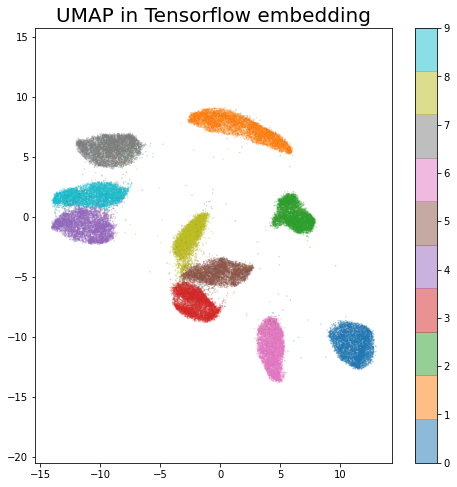

In [11]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### plotting loss

In [12]:
embedder._history.keys()

dict_keys(['loss'])

Text(0.5, 0, 'Epoch')

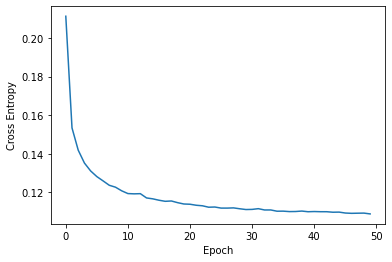

In [13]:
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')